Here, we are importing in the relevant libraries needed to execute the code. Os, pandas, and numpy will be used to process the raw dataset and ensure that the data is ready for the machine learning tools we use. The statsmodels libraries will be used to import the relevant methods and functions to execute the two-stage linear regression. Matplotlilb and seaborn will be used to plot and visually display the results of our linear regression.

In [143]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns



Here we are loading in the dataset and preprocessing it using the fillna method to ensure there are no gaps in the data and to replace gaps with a 0.

In [144]:
def load_data(file_name):
    current_dir = os.getcwd()
    os.chdir(current_dir)
    data = pd.read_csv(file_name)
    # Drop rows with NaN values
    data.fillna('0')
    return data

# OLS Regression


In [145]:
df = load_data('mergedReplicationData3.csv')

df

,Unnamed: 0,isocode,country_x,ln_maddison_pcgdp2000,ln_export_area,ln_export_pop,colony0,colony1,colony2,colony3,colony4,colony5,colony6,colony7,abs_latitude,longitude,rain_min,humid_max,low_temp,ln_coastline_area,island_dum,islam,legor_fr,legor_uk,region_n,region_s,region_w,region_e,region_c,ln_avg_gold_pop,ln_avg_oil_pop,ln_avg_all_diamonds_pop,ln_pop_dens_1400,atlantic_distance_minimum,indian_distance_minimum,saharan_distance_minimum,red_sea_distance_minimum,ethnic_fractionalization,state_dev,land_area,LN_GDPPC$_2021,Country Name,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,YR1969,YR1970,YR1971,YR1972,YR1973,YR1974,YR1975,YR1976,YR1977,YR1978,YR1979,YR1980,YR1981,YR1982,YR1983,YR1984,YR1985,YR1986,YR1987,YR1988,YR1989,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,LNYR1960,LNYR1961,LNYR1962,LNYR1963,LNYR1964,LNYR1965,LNYR1966,LNYR1967,LNYR1968,LNYR1969,LNYR1970,LNYR1971,LNYR1972,LNYR1973,LNYR1974,LNYR1975,LNYR1976,LNYR1977,LNYR1978,LNYR1979,LNYR1980,LNYR1981,LNYR1982,LNYR1983,LNYR1984,LNYR1985,LNYR1986,LNYR1987,LNYR1988,LNYR1989,LNYR1990,LNYR1991,LNYR1992,LNYR1993,LNYR1994,LNYR1995,LNYR1996,LNYR1997,LNYR1998,LNYR1999,LNYR2000,LNYR2001,LNYR2002,LNYR2003,LNYR2004,LNYR2005,LNYR2006,LNYR2007,LNYR2008,LNYR2009,LNYR2010,LNYR2011,LNYR2012,LNYR2013,LNYR2014,LNYR2015,LNYR2016,LNYR2017,LNYR2018,LNYR2019,LNYR2020,LNYR2021,LNYR2022
0,0,AGO,Angola,6.670766,7.967493,14.399250,0,0,0,1,0,0,0,0,8.0,17.54142,0,78,14,0.246860,0,0.0,1,0,0,0,0,0,1,-6.614335,0.643126,-1.701396,-0.024917,5.668760,6.980571,4.925892,3.872354,0.7867,0.635,1.250000,1927.474078,Angola,149.424925,153.938810,153.915187,160.187473,174.315964,187.431889,190.695770,190.195307,197.405851,208.863566,216.613476,229.886577,257.357496,326.092478,409.285233,482.673492,530.134193,558.590405,612.136752,736.499975,712.369763,643.439974,620.736572,623.909304,637.903551,758.088489,684.901344,756.427545,793.391428,892.340076,949.921356,850.556180,657.654640,466.679163,329.691784,398.120223,454.375004,516.127849,423.403332,387.689415,556.884244,527.464118,872.657638,982.805590,1254.696126,1900.723816,2597.963585,3121.348735,4081.717497,3123.698898,3586.663680,4608.155166,5083.826851,5061.349240,5011.984412,3217.339244,1809.709377,2439.374441,2540.508878,2191.347764,1450.905112,1927.474078,3000.444231,5.006794,5.036555,5.036402,5.076345,5.160870,5.233416,5.250679,5.248051,5.285262,5.341681,5.378115,5.437586,5.550466,5.787181,6.014412,6.179340,6.273130,6.325416,6.416956,6.601909,6.568597,6.466829,6.430907,6.436005,6.458187,6.630800,6.529275,6.628607,6.676317,6.793847,6.856379,6.745890,6.488680,6.145642,5.798158,5.986754,6.118923,6.246355,6.048325,5.960205,6.322357,6.268081,6.771543,6.890411,7.134649,7.549990,7.862483,8.046020,8.314273,8.046773,8.184978,8.435583,8.533820,8.529388,8.519587,8.076310,7.500922,7.799497,7.840120,7.692272,7.279943,7.563966,8.006516
1,1,BDI,Burundi,6.354370,1.140843,4.451658,0,0,0,0,1,0,0,0,16.0,29.88722,5,82,17,-4.605170,0,1.0,1,0,0,0,0,1,0,-2.633923,-9.210340,-6.907755,3.036856,10.626214,2.570375,3.718742,2.215324,0.2951,0.995,0.027800,221.157803,Burundi,71.360224,72.088782,73.942008,78.948269,85.964725,50.990420,51.808640,54.450305,54.647466,55.543775,69.395109,70.585523,68.955330,85.214644,94.333463,112.286107,117.051879,139.413264,151.067992,189.125941,213.253435,215.787603,220.157010,229.117726,203.859830,232.411825,238.356917,219.371301,205.317919,207.291950,206.444928,208.656723,188.581167,168.964076,165.585935,168.627168,146.536182,164.233446,148.089543,130.753024,138.004617,135.606476,124.139302,114.367007,128.538422,151.188541,166.276245,170.706876,194.710635,204.544756,222.660583,236.451347,238.205945,241.547666,257.818557,289.359627,242.539527,244.145422,232.060617,216.972971,216.827417,221.157803,259.025031,4.267741,4.277898,4.303281,4.368793,4.45393

here we are importing multiple libraries from the larger sklearn library to ensure we can execute a double lasso regression. LassoCV enables us to use cross-validation on our dataset, train_test_split allows us to split the data into training and testing datasets to ensure we can train the lasso regression before executing it on the testing dataset. StandardScaler allows us to scale the features of our dataset by reducing the impact of outliers on the dataset while maintaining the information contained within the dataset. Mean_squared_error and r2_score allows us to evaluate the effectiveness of our regression by identifying the relevant variables at each stage of the double lasso.

In [146]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS, add_constant

def doubleLasso(df, target_column, independent_vars):
    # Extract the independent variables (X) and the dependent variable (y) from the DataFrame
    X = df[independent_vars].values
    y = df[target_column].values

    # Scaling features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # First Lasso: Variable selection
    lasso1 = LassoCV(cv=10, random_state=42, eps=0.001, max_iter=10000).fit(X_train, y_train)
    selected_features = np.where(lasso1.coef_ != 0)[0]

    # Ensure that selected_features is not empty
    if len(selected_features) == 0:
        print("No features selected by the first Lasso. Try adjusting the parameters.")
        return None

    # Extracting the selected features for the second Lasso
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    # Second Lasso: Estimation using selected features
    lasso2 = LassoCV(cv=10, random_state=42).fit(X_train_selected, y_train)

    # Printing selected features and their coefficients
    selected_vars = [independent_vars[i] for i in selected_features]
    print(f"Selected Features: {selected_vars}")

    # Fit OLS on selected features from the first Lasso for interpretation
    X_train_ols = sm.add_constant(X_train[:, selected_features])
    model_ols = sm.OLS(y_train, X_train_ols).fit()

    # Print the summary of the OLS model
    print(model_ols.summary())

    # Get coefficients and standard errors
    coefficients = model_ols.params
    standard_errors = model_ols.bse

    # Optionally, return a DataFrame containing the results
    results_df = pd.DataFrame({
        "Feature": ["Intercept"] + selected_vars,
        "Coefficient": coefficients,
        "Standard Error": standard_errors
    })

    return results_df

# Usage example
# df = pd.read_csv('your_data.csv')  # Load your DataFrame with appropriate columns
# independent_vars = ['feature1', 'feature2', 'feature3', ...]  # Adjust with your actual variables
# target_column = 'target'
# results_df = doubleLasso(df, target_column, independent_vars)
# print(results_df)


In [147]:
import pandas as pd

# Define your independent variables
independent_vars = ['ln_export_area', 'ln_export_pop', 'abs_latitude', 'longitude',
                    'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum',
                    'islam', 'legor_fr', 'legor_uk', 'region_n', 'region_s', 'region_w',
                    'region_e', 'region_c', 'ln_avg_gold_pop', 'ln_avg_oil_pop',
                    'ln_avg_all_diamonds_pop', 'ln_pop_dens_1400', 'atlantic_distance_minimum', 
                    'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']

# Define your data file
data_path = 'mergedReplicationData3.csv'

# Load the data once to avoid reading the file multiple times in the loop
df = pd.read_csv(data_path)

# Initialize an empty DataFrame to store all results
all_results = pd.DataFrame()

# Loop over the years
for year in range(1990, 2022):  # Includes 2021
    target_column = f'LNYR{year}'
    
    # Ensure the DataFrame contains the target column
    if target_column in df.columns:
        year_df = df[[target_column] + independent_vars]
        
        # Call the doubleLasso function
        result = doubleLasso(year_df, target_column, independent_vars)
        
        if result is not None:
            result['Year'] = year  # Add year column to distinguish results
            all_results = pd.concat([all_results, result], axis=0)
        else:
            print(f"No valid results for {year}. Skipping to next year.")
    else:
        print(f"Column {target_column} not found in the DataFrame for year {year}.")

# Reset the index if you want to clean up the DataFrame's look
all_results.reset_index(inplace=True, drop=True)

# Save all results to a CSV file
all_results.to_csv('all_years_results.csv', index=False)
print("Results for all years have been processed and saved.")


Selected Features: ['ln_export_area', 'abs_latitude', 'rain_min', 'region_n', 'ln_avg_oil_pop', 'ln_pop_dens_1400']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     9.182
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           5.41e-06
Time:                        13:30:07   Log-Likelihood:                -38.095
No. Observations:                  41   AIC:                             90.19
Df Residuals:                      34   BIC:                             102.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

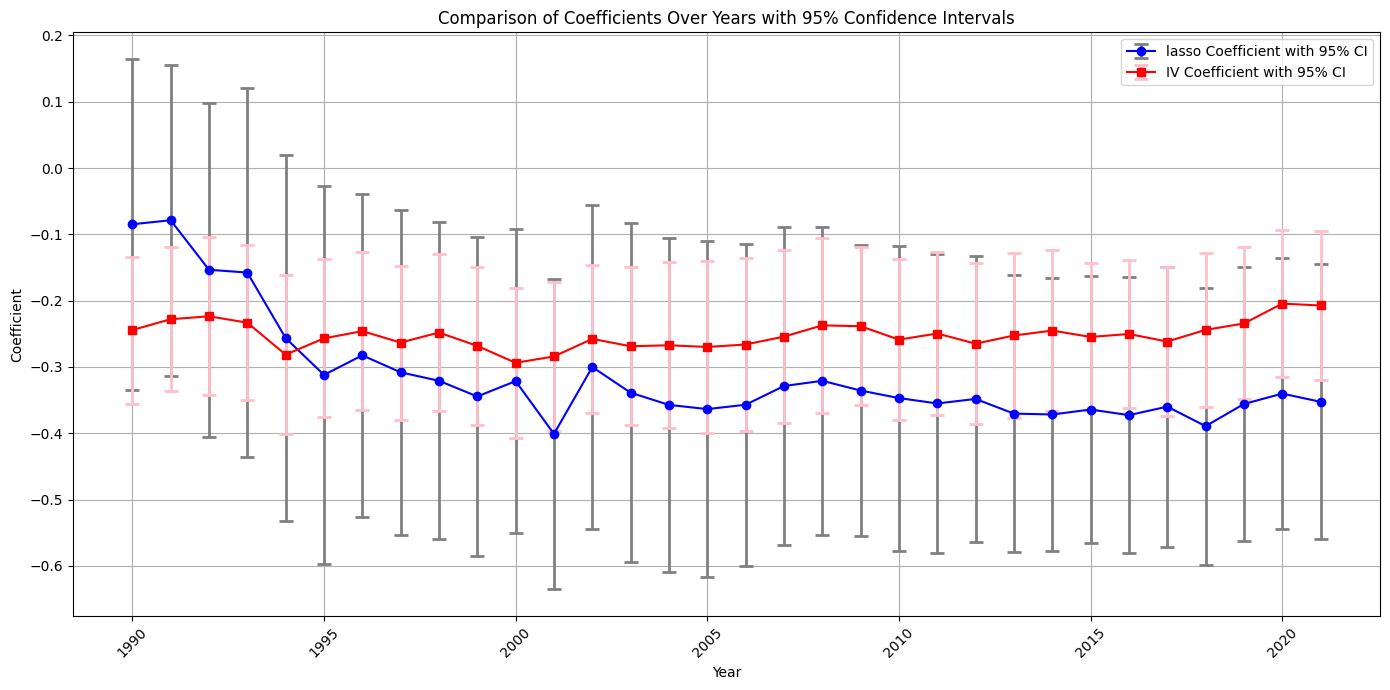

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# Load IV analysis results
results_df = pd.read_csv('IV_analysis_results.csv')
results_df = results_df.set_index('Year')

# Load data for all years
df = pd.read_csv('all_years_results.csv')
ln_export_area_data = df[df['Feature'] == 'ln_export_area']

# Extract necessary columns
years = ln_export_area_data['Year'].values
coefficients = ln_export_area_data['Coefficient'].values
standard_errors = ln_export_area_data['Standard Error'].values

# Calculate confidence intervals (95% CI)
ci_multiplier = 1.96  # Z-value for 95% CI from the standard normal distribution
lower_bounds = coefficients - ci_multiplier * standard_errors
upper_bounds = coefficients + ci_multiplier * standard_errors

# Plotting
plt.figure(figsize=(14, 7))
plt.errorbar(years, coefficients, yerr=[coefficients - lower_bounds, upper_bounds - coefficients],
             fmt='o-', color='blue', ecolor='gray', elinewidth=2, capsize=5, capthick=2,
             label='lasso Coefficient with 95% CI')

# Plot IV regression coefficients and standard errors
iv_coefficients = results_df['Coefficients_predicted_ln_export_area']
iv_standard_errors = results_df['Standard Errors_predicted_ln_export_area']
iv_lower_bounds = iv_coefficients - ci_multiplier * iv_standard_errors
iv_upper_bounds = iv_coefficients + ci_multiplier * iv_standard_errors
plt.errorbar(iv_coefficients.index, iv_coefficients, yerr=[iv_coefficients - iv_lower_bounds, iv_upper_bounds - iv_coefficients],
             fmt='s-', color='red', ecolor='pink', elinewidth=2, capsize=5, capthick=2,
             label='IV Coefficient with 95% CI')

# Annotations and aesthetics
plt.title('Comparison of Coefficients Over Years with 95% Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate years for better visibility if necessary
plt.legend()
plt.tight_layout()
plt.show()



Using the results of our double lasso regression, the selected variables will be inserted into the two-stage OLS regression with GDP in 1990, 2000, 2010, and 2021 being the dependent variables in 4 separate regressions. The loops allow us to conduct a regression for each year separately and save the coefficients to .csv file where the results can be analyzed.